# Gumbel softmax/sigmoid

Goal: Understanding details of gumbel-softmax and implement gumbel-sigmoid

- Standard gumbel distribution 으로부터 샘플링하는 코드 자체가 다 제각기 다른데, 그중에서도 pytorch official code 가 제일 이상함. 잘 되는지 확인해보자.

- Cumulative distribution function of gumbel distribution

$$F(x; \mu, \beta) = e^{-e^{-(x-\mu)/\beta}}$$

## Standard gumbel distribution

- Cumulative distribution function

$$F(x)=e^{-e^{-x}}$$

- Probability density function

$$f(x)=e^{-(x+e^{-x})}$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

In [2]:
# https://gist.github.com/yzh119/fd2146d2aeb329d067568a493b20172f
def sample_gumbel(shape, eps=1e-20):
    # Cumultaive distribution 으로부터 역으로 계산해서 샘플링
    # torch.rand: U ~ [0, 1] 이므로, U=F(x) 로 두고 x 를 역으로 찾는 것.
    U = torch.rand(shape)
    return -(-(U + eps).log() + eps).log()

In [3]:
# https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
def sample_gumbel2(shape):
    # 대체 무슨 코드인가 했는데, exponential_() 이 exp() 가 아님; e^{-x} 라는 exponential distribution 으로부터 샘플링해주는 함수.
    # 즉, empty 로 텐서를 만든 다음 그 안을 standard (lambda=1) exp dist 에서 샘플링해서 채우는 것.
    gumbels = (
        -torch.empty(shape, memory_format=torch.legacy_contiguous_format).exponential_().log()
    )  # ~Gumbel(0,1)
    return gumbels

In [4]:
def sample_gumbel3(shape):
    gumbel = torch.distributions.gumbel.Gumbel(0, 1)
    return gumbel.sample(shape)

In [5]:
N = 1000000

(tensor(0.5767), tensor(1.2811))

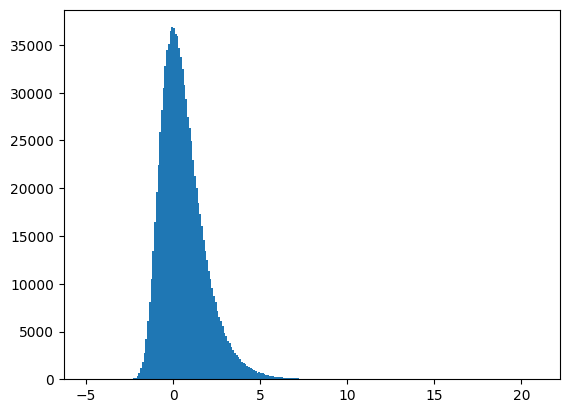

In [6]:
bins = np.arange(-5, 21, 0.1)

r = sample_gumbel([N])
plt.hist(r.numpy(), bins=bins);
r.mean(), r.std()

(tensor(0.5786), tensor(1.2835))

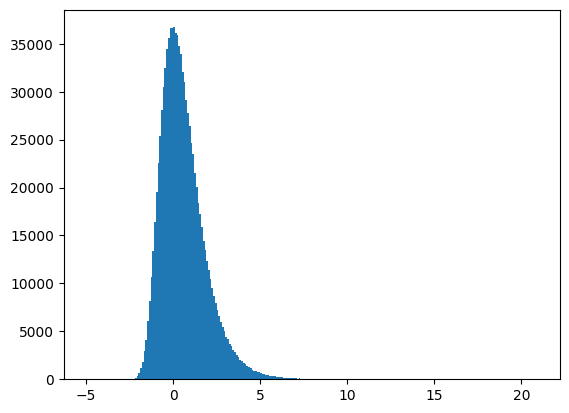

In [7]:
r = sample_gumbel2([N])
plt.hist(r.numpy(), bins=bins);
r.mean(), r.std()

(tensor(0.5773), tensor(1.2817))

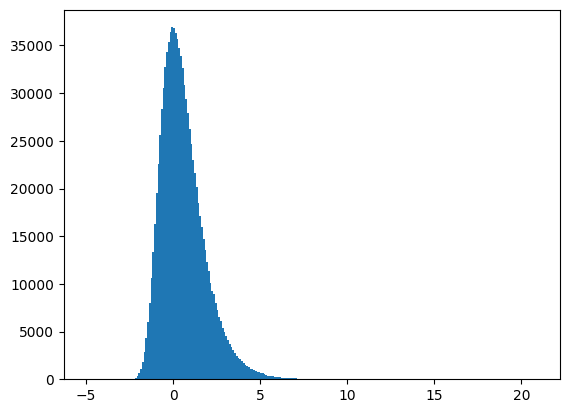

In [8]:
r = sample_gumbel3([N])
plt.hist(r.numpy(), bins=bins);
r.mean(), r.std()

# Sigmoid and Softmax

- gumbel sigmoid 를 eps 없이 짜고 싶담.

In [9]:
t = torch.rand(1, 10)

In [10]:
t.sigmoid()

tensor([[0.6747, 0.5526, 0.5967, 0.6656, 0.6584, 0.6869, 0.5082, 0.6460, 0.7290,
         0.6309]])

In [11]:
# mimic sigmoid using softmax
zt = torch.stack([torch.zeros_like(t), t], dim=-1)
zt.softmax(-1)[:, :, 1]

tensor([[0.6747, 0.5526, 0.5967, 0.6656, 0.6584, 0.6869, 0.5082, 0.6460, 0.7290,
         0.6309]])

In [12]:
def gumbel_sigmoid(logits: torch.Tensor, tau:float = 1, hard: bool = False):
    """Samples from the Gumbel-Sigmoid distribution and optionally discretizes.
    """
    logits = torch.stack([torch.zeros_like(logits), logits], dim=-1)
    return F.gumbel_softmax(logits, tau, hard, dim=-1)[..., -1]

In [13]:
# 이렇게 직접 짤 수도.
def gumbel_sigmoid2(logits: torch.Tensor, tau:float = 1, hard: bool = False):
    """Samples from the Gumbel-Sigmoid distribution and optionally discretizes.
    
    References:
        - https://github.com/yandexdataschool/gumbel_dpg/blob/master/gumbel.py
        - https://pytorch.org/docs/stable/_modules/torch/nn/functional.html#gumbel_softmax
    """
    gumbels1 = -torch.empty_like(logits).exponential_().log() # ~Gumbel(0,1)
    gumbels2 = -torch.empty_like(logits).exponential_().log() # ~Gumbel(0,1)
    
    gumbels = (logits + gumbels1 - gumbels2) / tau  # ~Gumbel(logits,tau) - ?
    y_soft = gumbels.sigmoid()

    if hard:
        # Straight through.
        y_hard = y_soft.gt(0.5).float()
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft

    return ret

In [28]:
# 검벨 노이즈를 두번 샘플링 해서 빼주는 것과 그냥 하나만 더해주는 게 어떻게 다른가?
# 두번 샘플링 해서 빼면 Logsitic distribution 이 됨. 아래 One-step-more 섹션 참고.
def gumbel_sigmoid3(logits: torch.Tensor, tau:float = 1, hard: bool = False):
    logistic = sample_standard_logistic(logits.shape)

    gumbels = (logits + logistic) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.sigmoid()

    if hard:
        # Straight through.
        y_hard = y_soft.gt(0.5).float()
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft

    return ret

In [43]:
# !!! 잘못된 구현 !!!
def gumbel_sigmoid4(logits: torch.Tensor, tau: float = 1, hard: bool = False, threshold: float = 0.5):
    """https://github.com/AngelosNal/PyTorch-Gumbel-Sigmoid/blob/main/gumbel_sigmoid.py#L6 (잘못된 구현!!)
    
    gumbel-softmax 코드를 그대로 가져와서 sigmoid 로만 바꿔 놔서 문제가 있는 듯.
    아래 테스트에서 gumbel_sigmoid 함수랑 결과가 다른 걸 확인할 수 있음.
    """
    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format).exponential_().log()
    )  # ~Gumbel(0, 1)
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits, tau)
    y_soft = gumbels.sigmoid()

    if hard:
        # Straight through.
        indices = (y_soft > threshold).nonzero(as_tuple=True)
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format)
        y_hard[indices[0], indices[1]] = 1.0
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [41]:
def gumbel_sigmoid_tcl(logits: torch.Tensor, tau: float = 1, hard: bool = False, threshold: float = 0.5):
    # https://github.com/kakaobrain/tcl/blob/main/models/tcl/gumbel.py
    logistic = torch.rand_like(logits)
    logistic = logistic.div_(1. - logistic).log_()  # ~Logistic(0,1)

    gumbels = (logits + logistic) / tau  # ~Logistic(logits, tau)
    y_soft = gumbels.sigmoid_()

    if hard:
        # Straight through.
        y_hard = y_soft.gt(0.5).type(y_soft.dtype)
        # gt_ break gradient flow
        #  y_hard = y_soft.gt_(0.5)  # gt_() maintain dtype, different to gt()
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft

    return ret

In [29]:
def tostr(tensor):
    return ", ".join(map(lambda x: f"{x:.4f}", tensor.numpy()))

def test(fn, N, ndim, t=None, hard=False):
    if t is None:
        t = torch.rand(ndim) * 5
    s = torch.zeros(ndim)

    print("sig:", tostr(t.sigmoid()))

    for i in range(N):
        r = fn(t, hard=hard)
        s += r

    s /= N
    print("avg:", tostr(s))

In [34]:
N = 500000
ndim = 12
t = torch.randn(ndim) * 3
hard = False

In [35]:
test(gumbel_sigmoid, N, ndim, t=t, hard=hard)

sig: 0.5029, 0.6027, 0.7692, 0.2946, 0.6712, 0.0732, 0.6479, 0.4333, 0.2670, 0.7595, 0.9778, 0.9347
avg: 0.5021, 0.5691, 0.6916, 0.3584, 0.6168, 0.1508, 0.6008, 0.4556, 0.3369, 0.6832, 0.9338, 0.8601


In [36]:
test(gumbel_sigmoid2, N, ndim, t=t, hard=hard)

sig: 0.5029, 0.6027, 0.7692, 0.2946, 0.6712, 0.0732, 0.6479, 0.4333, 0.2670, 0.7595, 0.9778, 0.9347
avg: 0.5016, 0.5689, 0.6916, 0.3585, 0.6174, 0.1505, 0.6007, 0.4558, 0.3372, 0.6839, 0.9341, 0.8604


In [37]:
test(gumbel_sigmoid3, N, ndim, t=t, hard=hard)

sig: 0.5029, 0.6027, 0.7692, 0.2946, 0.6712, 0.0732, 0.6479, 0.4333, 0.2670, 0.7595, 0.9778, 0.9347
avg: 0.5022, 0.5684, 0.6914, 0.3580, 0.6167, 0.1509, 0.6000, 0.4545, 0.3378, 0.6831, 0.9339, 0.8607


In [40]:
# wrong impl!
test(gumbel_sigmoid4, N, ndim, t=t, hard=hard)

sig: 0.5029, 0.6027, 0.7692, 0.2946, 0.6712, 0.0732, 0.6479, 0.4333, 0.2670, 0.7595, 0.9778, 0.9347
avg: 0.5989, 0.6742, 0.8017, 0.4275, 0.7264, 0.1742, 0.7086, 0.5443, 0.4013, 0.7939, 0.9792, 0.9387


In [42]:
test(gumbel_sigmoid_tcl, N, ndim, t=t, hard=hard)

sig: 0.5029, 0.6027, 0.7692, 0.2946, 0.6712, 0.0732, 0.6479, 0.4333, 0.2670, 0.7595, 0.9778, 0.9347
avg: 0.5016, 0.5691, 0.6917, 0.3585, 0.6169, 0.1508, 0.6007, 0.4560, 0.3375, 0.6835, 0.9339, 0.8606


## One step more

두 standard gumbel distribution 의 차는 standard logistic distribution 을 따른다고 함 (https://math.stackexchange.com/questions/637929/how-to-show-that-the-difference-of-two-gumbel-distributed-random-variables-follo)

$$X,Y\sim\text{Gumbel}[0,1]$$

then,

$$X-Y\sim\text{Logistic}[0,1]$$

- Cumulative distribution function of Logistic distribution

$$F(x ; \mu, s)=\frac{1}{1+e^{-(x-\mu) / s}}=\frac{1}{2}+\frac{1}{2} \tanh \left(\frac{x-\mu}{2 s}\right)$$

- Standard cumulative distribution function

$$
F(x)=\frac{1}{1+e^{-x}}
$$

In [22]:
from torch.distributions import SigmoidTransform

In [23]:
t = torch.rand(10)
print(t)
SigmoidTransform().inv(t).sigmoid()

tensor([0.2153, 0.4077, 0.3964, 0.2251, 0.1961, 0.2090, 0.9611, 0.8788, 0.0320,
        0.5049])


tensor([0.2153, 0.4077, 0.3964, 0.2251, 0.1961, 0.2090, 0.9611, 0.8788, 0.0320,
        0.5049])

In [24]:
# e^{-x} = 1/F(x) - 1
# x = -log(1/F(x) - 1)


def sample_standard_logistic(shape):
    return SigmoidTransform().inv(torch.rand(shape))

In [25]:
sample_standard_logistic([1, 12])

tensor([[ 0.3062,  2.8986, -1.1972, -1.9092,  2.4975,  0.9715, -2.0623,  1.5141,
         -0.8850, -0.2043, -0.6278,  0.4133]])